# imports

In [10]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import copy
import numpy as np
import os
from display_aux import *
from ships import SHIPS
from df_aux import *
from time_aux import *
from file_aux import *
from plot_aux import *
from parse_aux import *
import sys

In [11]:
ships = SHIPS()


In [12]:
%matplotlib ipympl

In [13]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)


# Run definitions

In [14]:
params = {}
params['input_csv_file_name_full'] = 'C:\\gilad\\work\\tip_and_que\\data\\AIS\\Combined\\Spire_AIS_Combined_All_20231101_1106_000000000000.csv'
# params['input_csv_file_name_full'] = 'debug_data_base.csv'

params['columns_list_keep'] = None
params['filter_vessels_df_dic'] = {
        'max_time_diff[mins]':['<=',30]
        }
params['reload_level'] = 1
params['reload_df_filt'] = False
params['reload_vessels'] = True
params['save_folder_base'] = './pkl'

params['export_to_excel'] = False
params['ana_vessel_name'] = 'EYVAN'
# params['df_filter_dic'] = {'position_timestamp':['<=','2023-11-01 02:00:00+0000']}
params['df_filter_dic'] = {}

# Load

In [15]:
save_folder = params['save_folder_base']+'/'+ get_file_base_name(params['input_csv_file_name_full'])
df = ships.load_raw_data(params['input_csv_file_name_full'],reload_level=params['reload_level'],save_folder=save_folder)

# filter_df
df = ships.prepare_df(df,reload_level=params['reload_level'],df_filter_dic=params['df_filter_dic'],save_folder=save_folder,columns_list_keep=params['columns_list_keep'])

# data_dic = ships.create_data_dic(df,reload_level=params['reload_level'],save_folder=save_folder)


load_row_data
----------------
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_org.pkl
filter_df
----------------
kuku
load df from ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_org.pkl
save df to ./pkl/Spire_AIS_Combined_All_20231101_1106_000000000000/df_filt.pkl


In [16]:
display(df.time.min())
display(df.time.max())

Timestamp('2023-11-01 00:00:00+0000', tz='UTC')

Timestamp('2023-11-01 01:27:53+0000', tz='UTC')

# map the mmsi's

In [17]:
def explore_mmsi(df):
    groups = df.groupby('mmsi')
    mmsi_dic = {mmsi:group for mmsi,group in groups}
    item_summary_dic = {}
    item_summary_dic['good_name'] = []
    item_summary_dic['nan_name'] = []
    mmsi_summary_dic['multiple_name'] = []

    for i,mmsi in enumerate(mmsi_dic.keys()):
        name = mmsi_dic[mmsi]['name'].unique()
        if name.shape[0]>1:
            mmsi_summary_dic['multiple_name'].append(mmsi)
        elif pd.isna(name):
            mmsi_summary_dic['nan_name'].append(mmsi)
        else:
            mmsi_summary_dic['good_name'].append(mmsi)    

    return mmsi_summary_dic





In [18]:
def get_item_df(df,item,item_type='mmsi',sort_columns=None):
    df_filt = df.loc[df[item_type]==item]

    if (sort_columns is not None):
        parse_parameter(sort_columns,df.columns)        

        df_filt.sort_values(by=sort_columns)

    return df_filt



def get_item_data_stats(item_data,item_type=None,id_column_check=[]):

    if (not isinstance(id_column_check,list)):
        id_column_check = [id_column_check]

    stats_dic = {
        item_type:item_data[item_type].unique().tolist(),
        'len': [item_data.shape[0]],  # Scalar value wrapped in a list
        'min_time':min(item_data['time']),
        'max_time':max(item_data['time']),
        'total_time':max(item_data['time'])- min(item_data['time']),
        'min_time_diff[mins]': round(np.min(time_diff_convert(item_data['time'].diff()))),
        'max_time_diff[mins]': round(np.max(time_diff_convert(item_data['time'].diff()))),
        'mean_time_diff[mins]': round(np.mean(time_diff_convert(item_data['time'].diff()))),
        'min_longitude':(min(item_data['longitude'])),
        'max_longitude':(max(item_data['longitude'])),
        'min_latitude':(min(item_data['latitude'])),
        'max_latitude':(max(item_data['latitude'])),
    }
    stats_dic['span_longitude']  = stats_dic['max_longitude']-stats_dic['min_longitude']
    stats_dic['span_latitude']  = stats_dic['max_latitude']-stats_dic['min_latitude']

    for column in id_column_check:
        stats_dic[f'num_{column}s'] = item_data[column].unique().shape[0]



    return stats_dic



def create_info_df(df,num_lines = None,item_type='mmsi',id_column_check='name'):
    print('create info_df')

    info_df = pd.DataFrame()
    prob_mmsi = []
    item_list = df[item_type].unique()

    if (num_lines != None):
        item_list = item_list[:num_lines]


    for i, item in enumerate(item_list):
        if (i % 1000 == 0):
            print(f'processing {item_type} {i} out of {len(item_list)}')
        item_data = get_item_df(df,item,item_type=item_type)  # Assuming get_item_data is defined elsewhere

        item = item_data[item_type].iloc[0]

        if (item_data.shape[0]==1):
            continue
        
        try:
            ships_df_line = pd.DataFrame(get_item_data_stats(item_data,item_type=item_type,id_column_check=id_column_check),index=[item])
        except Exception as e:
            # Print the exception message
            print(item)
            print(f"An error occurred: {e}")
            # Optionally, you can log the error or perform other actions here
            # Exit the program
            sys.exit(1)


        info_df = pd.concat([info_df, ships_df_line])

    info_df = info_df.sort_values(by='len', ascending=False)

    # info_df = info_df.reset_index(drop=True)
    return info_df





In [19]:
# example
ship_data = get_item_df(df,2335222,item_type='mmsi')

info_df = create_info_df(df,num_lines=1000)
info_df.head()

create info_df
processing mmsi 0 out of 1000


,mmsi,len,min_time,max_time,total_time,min_time_diff[mins],max_time_diff[mins],mean_time_diff[mins],min_longitude,max_longitude,min_latitude,max_latitude,span_longitude,span_latitude,num_names
4224100,4224100,397,2023-11-01 00:00:00+00:00,2023-11-01 01:27:40+00:00,0 days 01:27:40,0,1,0,49.064637,49.064690,30.425045,30.425112,0.000053,0.000067,1
2018004,2018004,365,2023-11-01 00:00:02+00:00,2023-11-01 01:27:52+00:00,0 days 01:27:50,0,1,0,121.764402,121.764473,40.885422,40.885508,0.000072,0.000087,1
5671038,5671038,329,2023-11-01 00:00:00+00:00,2023-11-01 01:27:50+00:00,0 days 01:27:50,0,1,0,98.440952,98.440993,8.067373,8.067417,0.000042,0.000043,1
538006719,538006719,286,2023-11-01 00:00:00+00:00,2023-11-01 01:27:00+00:00,0 days 01:27:00,0,2,0,54.158482,54.556240,26.364305,26.384470,0.397758,0.020165,1
4131512,4131512,280,2023-11-01 00:00:01+00:00,2023-11-01 01:27:51+00:00,0 days 01:27:50,0,3,0,122.120287,122.120362,37.560843,37.560968,0.000075,0.000125,1


# handle mutiple names per mmsi

In [20]:
def create_subplot_scheme(axes_size=(5, 2), num_axes=1, max_axes_in_row=4):
    """
    Creates a subplot scheme and returns an array of axes.

    Parameters:
    ----------
    axes_size : tuple
        Size of each individual subplot (width, height).

    num_axes : int
        Total number of subplots to create.

    max_axes_in_row : int, optional
        Maximum number of subplots in a row. Default is 4.

    Returns:
    -------
    fig : matplotlib.figure.Figure
        The created figure.

    axes : array-like of matplotlib.axes.Axes
        Array of created subplot axes.
    """
    # Calculate the number of rows and columns
    num_cols = min(max_axes_in_row, num_axes)
    num_rows = (num_axes + num_cols - 1) // num_cols  # Ceiling division to ensure all axes fit

    # Calculate figure size based on individual axes size
    fig_width = axes_size[0] * num_cols
    fig_height = axes_size[1] * num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), constrained_layout=True)
    
    # Flatten the axes array if there are multiple rows or columns
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Hide any unused subplots
    for i in range(num_axes, len(axes)):
        axes[i].set_visible(False)

    return fig, axes[:num_axes]



In [21]:
def parse_parameter(parameter, allowed_values):
    """
    Example function that only accepts specific values for its parameter.

    Parameters:
    - parameter: str, the input parameter which must be one of the allowed values.
    - allowed_values: list, the set of allowed values for the parameter.

    Raises:
    - ValueError: if the parameter is not in the allowed values.
    """
    
    
    if (isinstance(parameter,list)):
        for value in parameter:
            if value not in allowed_values:
                raise ValueError(f"Invalid value '{value}'. Allowed values are: {allowed_values}")
    else: 
        if parameter not in allowed_values:
            raise ValueError(f"Invalid value '{parameter}'. Allowed values are: {allowed_values}")
    


In [22]:
import matplotlib.pyplot as plt



def plot_df_columns(df, columns=None, axes=None, fig_size=(10, 6), title='Plot',x_data_type='index',time_column = 'time',normalize=False):
    """
    Plots specified columns from a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - columns: list of column names to plot. If None, all columns are plotted.
    - axes: matplotlib axes object. If None, a new figure and axes are created.
    - fig_size: tuple, the size of the figure.
    - title: str, the title of the plot.
    
    Returns:
    - axes: matplotlib axes object with the plot.
    """
    if columns is None:
        raise ValueError("columns is empty")
    
    elif not isinstance(columns,list):
        columns = [columns]
    
    parse_parameter(columns,df.columns)
    parse_parameter(x_data_type,['index','time'])

    if axes is None:
        fig, axes = plt.subplots(figsize=fig_size)
        created_fig = True
    else:
        created_fig = False

    if (x_data_type=='index'):
        x_data = range(df.shape[0])

    elif (x_data_type=='time'):
        x_data = df[time_column]
    

    for column in columns:
        if (normalize):
            y_data = (df[column]-df[column].min())/(df[column].max()-df[column].min())
        else:
            y_data = df[column]

        axes.plot(x_data, y_data, label=column)
    
    if (x_data_type=='time'):
        axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        for label in axes.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_fontsize(8)
        


    axes.set_title(title)
    axes.legend()
    
    if created_fig:
        plt.show()
    
    return axes



def plot_item_columns(df,item,item_type='mmsi',columns=['latitude','longitude'], axes_size=(3, 2), separate_y=True,normalize=False,x_data_type='index',sort_columms = None,pre_process=None):
    if not isinstance(item, list):
        item = [item]

    if columns is None:
        raise ValueError("columns is empty")
    
    elif not isinstance(columns,list):
        columns = [columns]

    fig, axes = create_subplot_scheme(axes_size=axes_size, num_axes=len(item))

    # Plotting on the created subplots
    for i, ax in enumerate(axes):
        if i > len(item):
            break

        # Assuming 'ships.get_item_df' is a function to filter the DataFrame by item
        df_filt = get_item_df(df, item[i],item_type=item_type)

        if (pre_process=='remove_bias'):
            for column in columns:
                df_filt.loc[:, column] = df_filt[column] - df_filt[column].mean()


        plot_df_columns(df_filt,columns=columns,axes=ax,x_data_type=x_data_type,title=f'{item_type}={item[i]}')
        
        # # Plotting the specified columns
        # for column in columns:
        #     ax.plot(df_filt[column], label=column)
        # ax.set_title(f'MMSI: {mmsi[i]}')
        # ax.legend()

    plt.show()








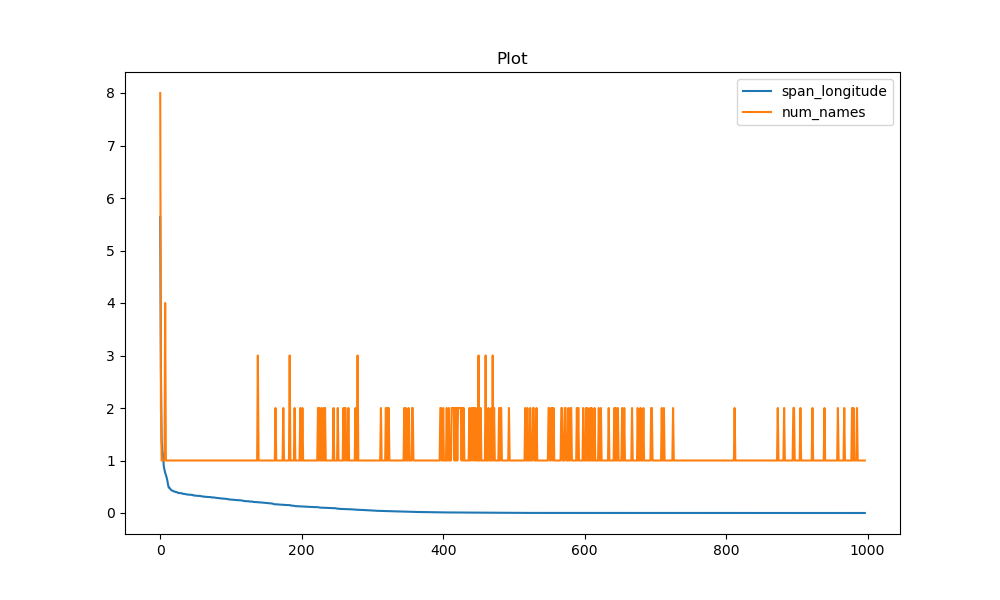

In [23]:
info_df = info_df.sort_values(by='span_longitude',ascending=False)
info_df1 = info_df.reset_index(drop=True)
plot_df_columns(info_df1,columns=['span_longitude','num_names'])
pd.set_option('display.max_rows', 30)


In [24]:
pd.set_option('display.max_rows', 40)

item_df = get_item_df(df,info_df.index[17],item_type='mmsi')
item_df['name'].unique()

display(info_df.head(40))

,mmsi,len,min_time,max_time,total_time,min_time_diff[mins],max_time_diff[mins],mean_time_diff[mins],min_longitude,max_longitude,min_latitude,max_latitude,span_longitude,span_latitude,num_names
412888888,412888888,63,2023-11-01 00:00:01+00:00,2023-11-01 01:27:53+00:00,0 days 01:27:52,0,5,1,119.823948,125.463307,28.009293,39.782487,5.639358,11.773193,8
412333327,412333327,45,2023-11-01 00:00:02+00:00,2023-11-01 01:26:37+00:00,0 days 01:26:35,0,9,2,120.100415,122.791637,37.683222,38.657150,2.691222,0.973928,2
352135000,352135000,100,2023-11-01 00:00:00+00:00,2023-11-01 01:26:59+00:00,0 days 01:26:59,0,5,1,122.124270,123.505575,29.632260,29.809703,1.381305,0.177443,1
413269960,413269960,57,2023-11-01 00:00:01+00:00,2023-11-01 01:27:35+00:00,0 days 01:27:34,0,5,2,121.148680,122.314067,37.670873,37.954293,1.165387,0.283420,1
636020221,636020221,125,2023-11-01 00:00:00+00:00,2023-11-01 01:25:32+00:00,0 days 01:25:32,0,4,1,121.838785,122.954023,29.682303,29.951253,1.115238,0.268950,1
563160900,563160900,106,2023-11-01 00:00:00+00:00,2023-11-01 01:27:08+00:00,0 days 01:27:08,0,6,1,121.844822,122.741520,29.691718,29.942818,0.896698,0.251100,1
538007028,538007028,119,2023-11-01 00:00:01+00:00,2023-11-01 01:27:53+00:00,0 days 01:27:52,0,4,1,121.974723,122.797173,29.694725,29.944803,0.822450,0.250078,1
413123456,413123456,56,2023-11-01 00:00:01+00:00,2023-11-01 01:27:00+00:00,0 days 01:26:59,0,5,2,121.392643,122.159282,30.437602,40.350267,0.766638,9.912665,4
440078820,440078820,11,2023-11-01 00:00:01+00:00,2023-11-01 00:56:02+00:00,0 days 00:56:01,0,15,6,125.647308,126.369073,37.302665,37.337862,0.721765,0.035197,1
239737000,239737000,62,2023-11-01 00:00:01+00:00,2023-11-01 01:27:42+00:00,0 days 01:27:41,0,5,1,25.090350,25.770967,37.310783,37.403550,0.680617,0.092767,1


# look at good ones

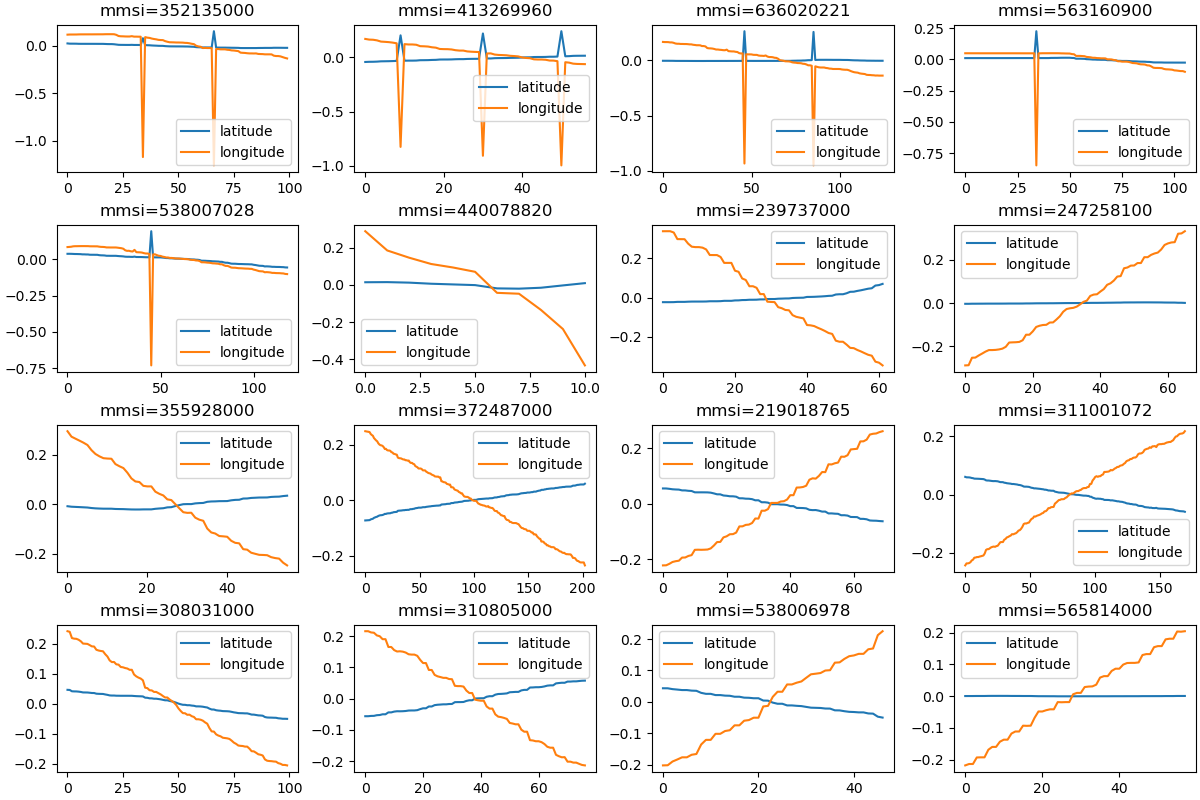

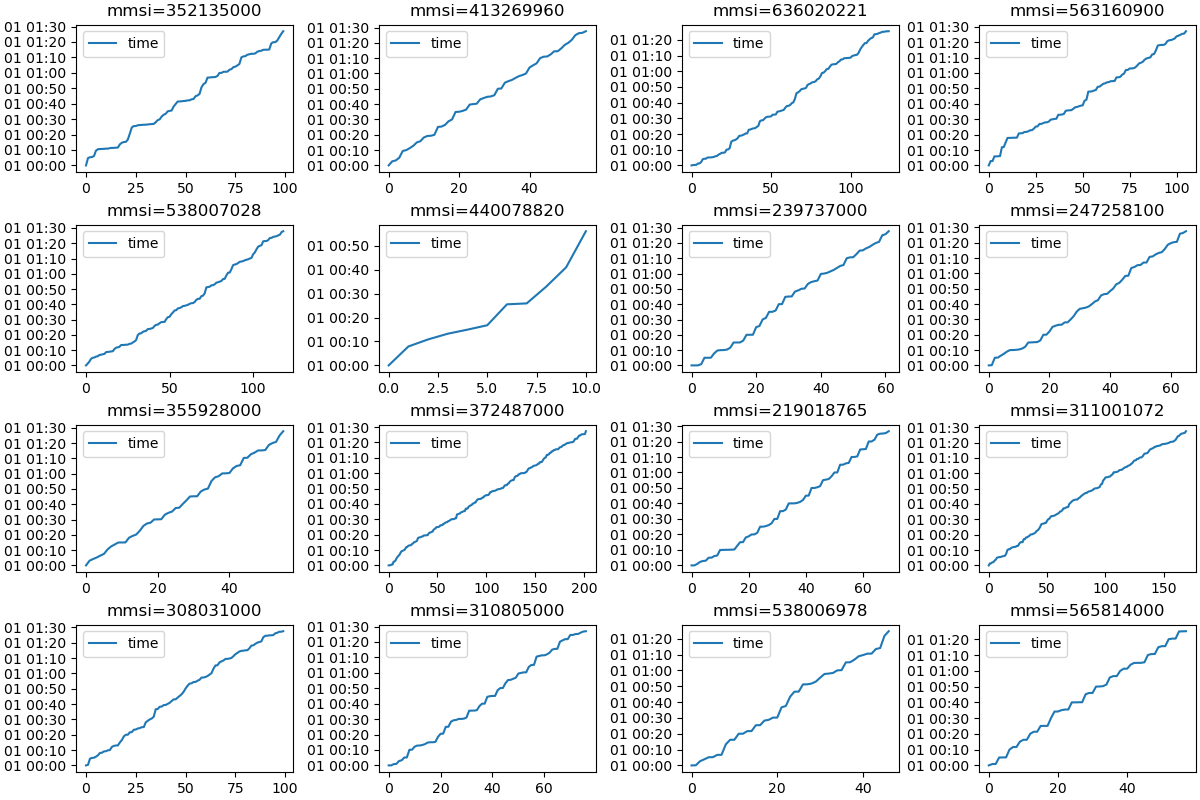

In [25]:

info_df_filter = {'len': ['>',10],
                    'num_names':['==',1]}

info_df_filt = filter_df(info_df,info_df_filter)

mmsi = info_df_filt.index[range(16)].tolist()
plot_item_columns(df,mmsi,x_data_type='index',columns=['latitude','longitude','time_seconds'],sort_columms='latitued',pre_process='remove_bias')
plot_item_columns(df,mmsi,x_data_type='index',columns=['time'],sort_columms='latitued')


# Look at bad ones

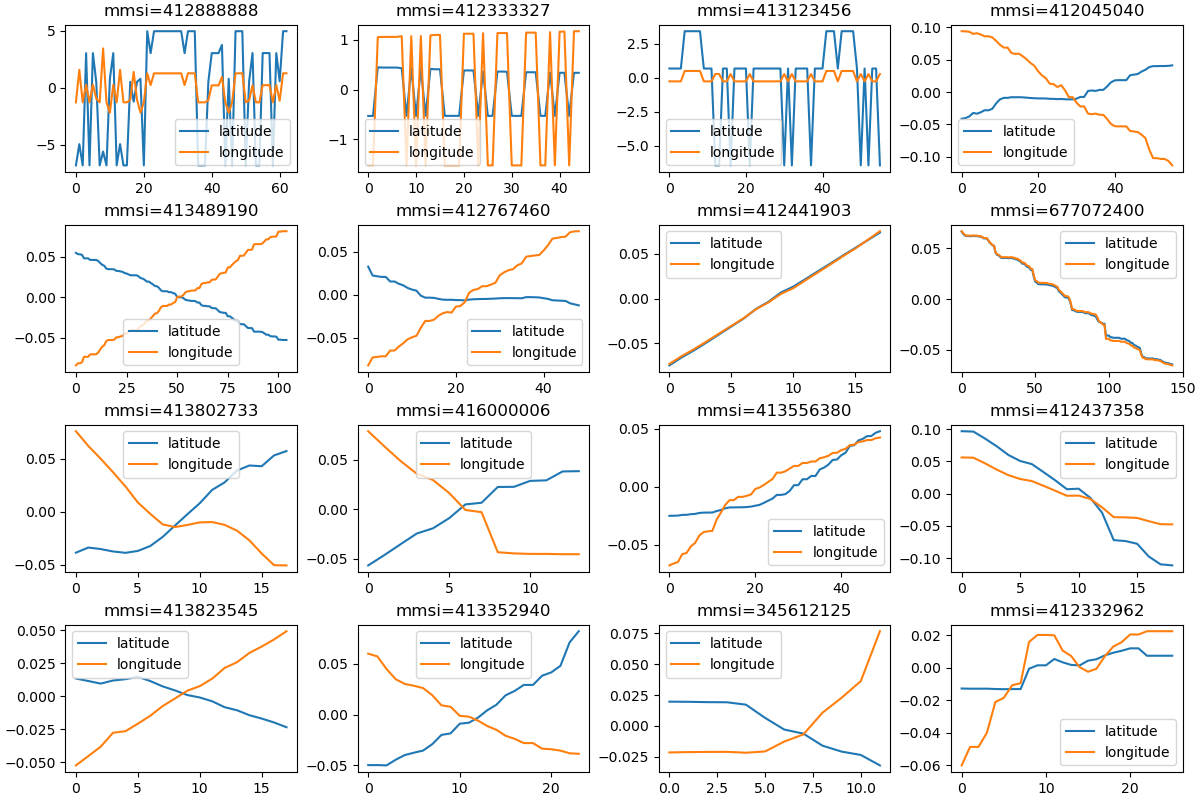

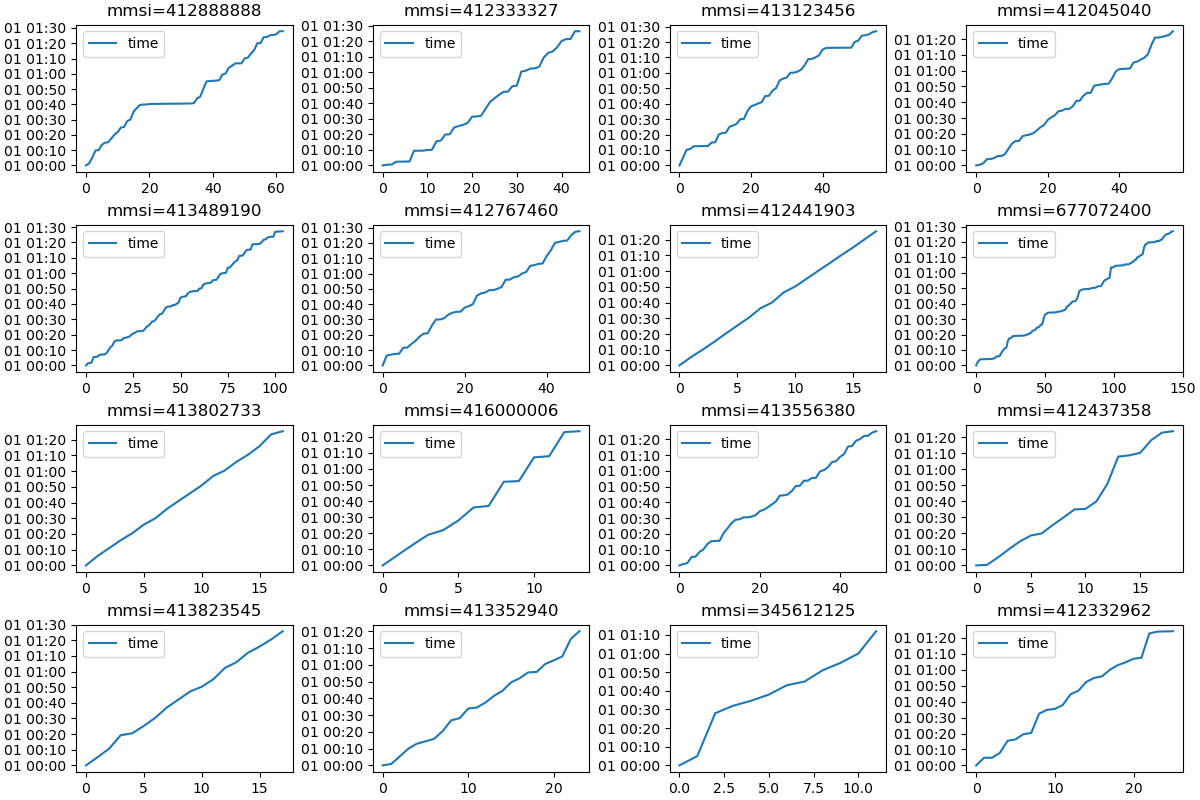

In [26]:

info_df_filter = {'len': ['>',10],
                    'num_names':['>=',2]}

info_df_filt = filter_df(info_df,info_df_filter)
# display(info_df_filt)


mmsi = info_df_filt.index[range(16)].tolist()
plot_item_columns(df,mmsi,x_data_type='index',columns=['latitude','longitude'],sort_columms='latitued',pre_process='remove_bias')
plot_item_columns(df,mmsi,x_data_type='index',columns=['time'],sort_columms='latitued')

